In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 20)

from math import ceil
from collections import Counter
import random
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils.validation import check_is_fitted

import category_encoders as ce

# Home Credit Default Risk

The dataset of the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition is composed of multiple files with information about loans taken. We're going to exclusively work with the main files: application_train.csv and application_test.csv.

This is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay its debt or not.

We will evaluate with the [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419), our models will have to return the probabilities that a loan is not paid for each row.

To access the data for this project, you only need to execute the code below. This will download three files:

- `application_train.csv`: Training dataset you must use to train and find the best hyperparameters on your model.
- `application_test.csv`: Test dataset, use it only when you are done choosing the model and the parameters.
- `HomeCredit_columns_description.csv`: This file contains descriptions for the columns in train and test datasets.

In [4]:
!pip install gdown

!gdown 1CAhmDRZLsIX1rYmUHOI8n2oatGQKGeHt
!gdown 1jXsI16FglcBCKID1c5Us-WD758D6mWMD
!gdown 1i96_nh9tU0YeQtbLGusjZxVp3cBctDGp

In [4]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
df = pd.read_csv("HomeCredit_columns_description.csv")[["Row", "Description", "Special"]]

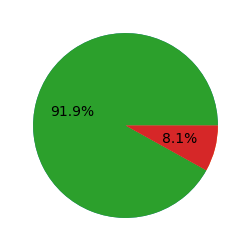

In [5]:
df1=round(app_train["TARGET"].value_counts() / len(app_train["TARGET"]) * 100,2)
plt.figure(figsize=(3,3));
plt.pie(df1)
plt.pie(df1, autopct='%1.1f%%')
plt.show()

In [7]:
if isinstance(app_train, pd.DataFrame):
  print('Success: app_train type is correct!')
else:
  raise ValueError('Train dataset type is incorrect, please review your code')

Success: app_train type is correct!


### EDA

A lot of the analysis of the data can be found on public available Kaggle kernels or blog posts. Lets see some dataset properties.

In [8]:
(a, b, c, d) = app_train.shape + app_test.shape
if b==d:
    print(f"Train and test both have {b} columns")
print(f"The train dataset has {a} rows.")
print(f"The test dataset has {c} rows.")

nof_cols_to_print = 4 # resonable values 1, 2, 3, 4

list_train_cols = list(app_train.columns)
longest_col_name = max([len(x) for x in list_train_cols])
nof_rows_to_print = ceil(app_train.shape[1]/nof_cols_to_print)
for k in range(nof_cols_to_print*nof_rows_to_print - app_train.shape[1]):
    list_train_cols.append("")

print("Columns of the train dataset:\n\n")
for i in range(nof_rows_to_print):
    answer=" ".join([list_train_cols[i+j*nof_rows_to_print].ljust(1+longest_col_name) for j in range(nof_cols_to_print)])
    print(answer)

Train and test both have 123 columns
The train dataset has 215257 rows.
The test dataset has 92254 rows.
Columns of the train dataset:


Unnamed: 0                    REGION_RATING_CLIENT          YEARS_BUILD_MODE              DEF_30_CNT_SOCIAL_CIRCLE     
SK_ID_CURR                    REGION_RATING_CLIENT_W_CITY   COMMONAREA_MODE               OBS_60_CNT_SOCIAL_CIRCLE     
TARGET                        WEEKDAY_APPR_PROCESS_START    ELEVATORS_MODE                DEF_60_CNT_SOCIAL_CIRCLE     
NAME_CONTRACT_TYPE            HOUR_APPR_PROCESS_START       ENTRANCES_MODE                DAYS_LAST_PHONE_CHANGE       
CODE_GENDER                   REG_REGION_NOT_LIVE_REGION    FLOORSMAX_MODE                FLAG_DOCUMENT_2              
FLAG_OWN_CAR                  REG_REGION_NOT_WORK_REGION    FLOORSMIN_MODE                FLAG_DOCUMENT_3              
FLAG_OWN_REALTY               LIVE_REGION_NOT_WORK_REGION   LANDAREA_MODE                 FLAG_DOCUMENT_4              
CNT_CHILDREN           

In [10]:
if not app_train.TARGET.isna().any():
    print("The TARGET columns have no NaNs.\n")

print("Values of the TARGET column:")

df_target = pd.concat([app_train.TARGET.value_counts(dropna=False), app_train.TARGET.value_counts(normalize=True)], axis=1)
df_target.columns = ["totals", "percentage"]
df_target

The TARGET columns have no NaNs.

Values of the TARGET column:


,totals,percentage
0,197882,0.9193
1,17375,0.0807


## Number of columns of each data type.

In [11]:
counter_dicci = Counter(app_train.dtypes)
for x in counter_dicci:
    print(x, counter_dicci[x], sep="\t\t")

int64		42
object		16
float64		65


## Number of distinct values in each categorical column:

The categorical variables are not only the object type columns, but some int64 columns.

We store the int64 columns in 4 lists depending on the number of distinct values

In [12]:
integer_non_cat_cols, nonbinary_cat_cols, binary_cols, mono_train_cols = [], [], [], []

for x in app_train.select_dtypes(include="int64").columns:
    if app_train[x].nunique() > 4:
        integer_non_cat_cols.append(x)
    elif 2 < app_train[x].nunique():
        nonbinary_cat_cols.append(x)
    elif 2 == app_train[x].nunique():
        binary_cols.append(x)
    else:
        mono_train_cols.append(x)

The int64 columns with at least 5 different possible values are not categorical, the ones with less than 6 are categorical.

HOUR_APPR_PROCESS_START has 24 possible values(the hours of the day), but we will not consider it as categorical.

In [13]:
categoric_cols = list(app_train.select_dtypes(include="object").columns)

print("Categorical column".ljust(1+longest_col_name),"Nunique", "\n", "-"*40, "\n")
for x in categoric_cols + nonbinary_cat_cols:
    if app_train[x].nunique() > 2:
        print(f"{x}".ljust(1+longest_col_name),app_train[x].nunique())
        nonbinary_cat_cols.append(x)
    elif app_train[x].nunique() == 2:
        binary_cols.append(x)
    else:
        mono_train_cols.append(x)
    

print("\nAlso, the following are categorical-binary columns:\n\n")

nof_cols_to_print = 4
longest_col_name = max([len(x) for x in binary_cols])
nof_rows_to_print = ceil(len(binary_cols)/nof_cols_to_print)

binaries_string_list = [x for x in binary_cols]
for k in range(nof_cols_to_print*nof_rows_to_print - len(binaries_string_list)):
    binaries_string_list.append("")
    
for i in range(nof_rows_to_print):
    answer=" ".join([binaries_string_list[i+j*nof_rows_to_print].ljust(1+longest_col_name) for j in range(nof_cols_to_print)])
    print(answer)
    
print("\nAlso, the following columns have just 1 value in the train dataset:\n\n")
print(mono_train_cols)

Categorical column            Nunique 
 ---------------------------------------- 

CODE_GENDER                   3
NAME_TYPE_SUITE               7
NAME_INCOME_TYPE              8
NAME_EDUCATION_TYPE           5
NAME_FAMILY_STATUS            6
NAME_HOUSING_TYPE             6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START    7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE            4
HOUSETYPE_MODE                3
WALLSMATERIAL_MODE            7
REGION_RATING_CLIENT          3
REGION_RATING_CLIENT_W_CITY   3

Also, the following are categorical-binary columns:


TARGET                       REG_CITY_NOT_LIVE_CITY       FLAG_DOCUMENT_8              FLAG_DOCUMENT_17            
FLAG_EMP_PHONE               REG_CITY_NOT_WORK_CITY       FLAG_DOCUMENT_9              FLAG_DOCUMENT_18            
FLAG_WORK_PHONE              LIVE_CITY_NOT_WORK_CITY      FLAG_DOCUMENT_10             FLAG_DOCUMENT_19            
FLAG_CONT_MOBILE             FLAG_DOCUMENT_2              FLAG_D

### Now we show some binary columns with little variance

In [85]:
irrelevant_binary_cols = []
for x in binary_cols:
    if app_train[x].value_counts().values[1]<100:
        irrelevant_binary_cols.append(x)
        print(app_train[x].value_counts(), "\n\n")

0    215247
1        10
Name: FLAG_DOCUMENT_2, dtype: int64 


0    215237
1        20
Name: FLAG_DOCUMENT_4, dtype: int64 


0    215206
1        51
Name: FLAG_DOCUMENT_7, dtype: int64 


0    215252
1         5
Name: FLAG_DOCUMENT_10, dtype: int64 


0    215255
1         2
Name: FLAG_DOCUMENT_12, dtype: int64 


0    215206
1        51
Name: FLAG_DOCUMENT_17, dtype: int64 


0    215190
1        67
Name: FLAG_DOCUMENT_21, dtype: int64 




Some of them could be dropped.

## Percentage of missing data for each column ordered by percentage descending:

In [14]:
df_0 = app_train.isna().sum() \
                .sort_values(ascending=False)\
                .to_frame("total_nans") \
                .assign(percentage = lambda df_0: df_0["total_nans"]/len(app_train)) \

df_0[:20]

,total_nans,percentage
COMMONAREA_AVG,150393,0.6987
COMMONAREA_MODE,150393,0.6987
COMMONAREA_MEDI,150393,0.6987
NONLIVINGAPARTMENTS_MODE,149483,0.6944
NONLIVINGAPARTMENTS_AVG,149483,0.6944
NONLIVINGAPARTMENTS_MEDI,149483,0.6944
FONDKAPREMONT_MODE,147217,0.6839
LIVINGAPARTMENTS_MODE,147144,0.6836
LIVINGAPARTMENTS_MEDI,147144,0.6836
LIVINGAPARTMENTS_AVG,147144,0.6836


### Distribution of credit amounts.

In [15]:
app_train.AMT_CREDIT.describe()

count    215257.0000
mean     597645.2199
std      401497.5336
min       45000.0000
25%      270000.0000
50%      512145.0000
75%      808650.0000
max     4050000.0000
Name: AMT_CREDIT, dtype: float64

<AxesSubplot: xlabel='AMT_CREDIT'>

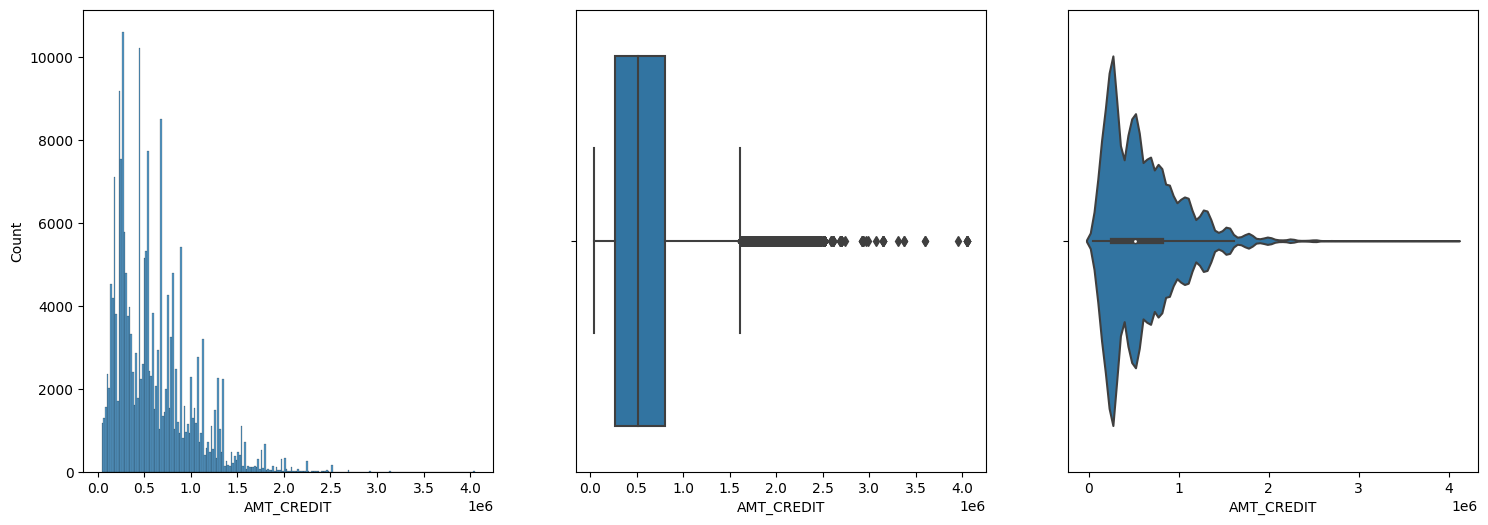

In [20]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
sns.histplot(data = app_train, x = "AMT_CREDIT", ax=ax[0])
sns.boxplot(data = app_train, x = "AMT_CREDIT", ax=ax[1])
sns.violinplot(data = app_train, x = "AMT_CREDIT", ax=ax[2])

## Education level of the credit applicants:

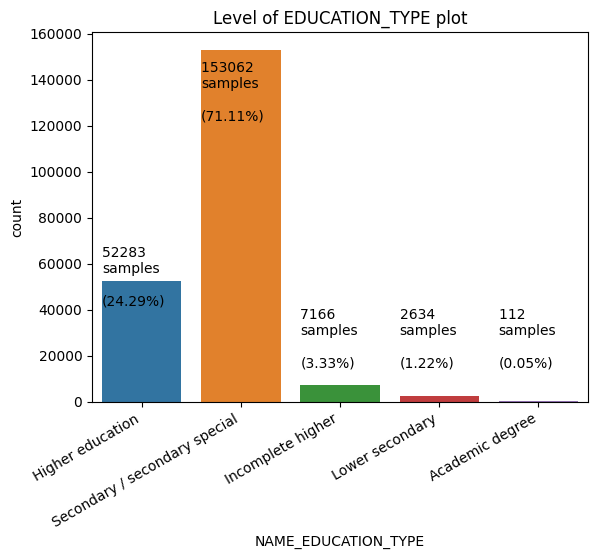

In [21]:
colu = "NAME_EDUCATION_TYPE"

chart = sns.countplot(data=app_train, x=colu, orient="v")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right')
chart.set_title(f"Level of {colu[5:]} plot")

for p in chart.patches:
    txt = str((p.get_height()*100/len(app_train)).round(2)) + '%'
    chart.text(p.get_x(),max(p.get_height()*.8, 15000) , f"{p.get_height()} \nsamples\n\n({txt})")

### Distribution of ocupation of the loan applicants

[Text(0, 0, 'Core staff'),
 Text(1, 0, 'Laborers'),
 Text(2, 0, 'High skill tech staff'),
 Text(3, 0, 'Accountants'),
 Text(4, 0, 'Security staff'),
 Text(5, 0, 'Drivers'),
 Text(6, 0, 'Realty agents'),
 Text(7, 0, 'Cleaning staff'),
 Text(8, 0, 'Waiters/barmen staff'),
 Text(9, 0, 'Cooking staff'),
 Text(10, 0, 'Sales staff'),
 Text(11, 0, 'Secretaries'),
 Text(12, 0, 'Managers'),
 Text(13, 0, 'Medicine staff'),
 Text(14, 0, 'Private service staff'),
 Text(15, 0, 'Low-skill Laborers'),
 Text(16, 0, 'IT staff'),
 Text(17, 0, 'HR staff')]

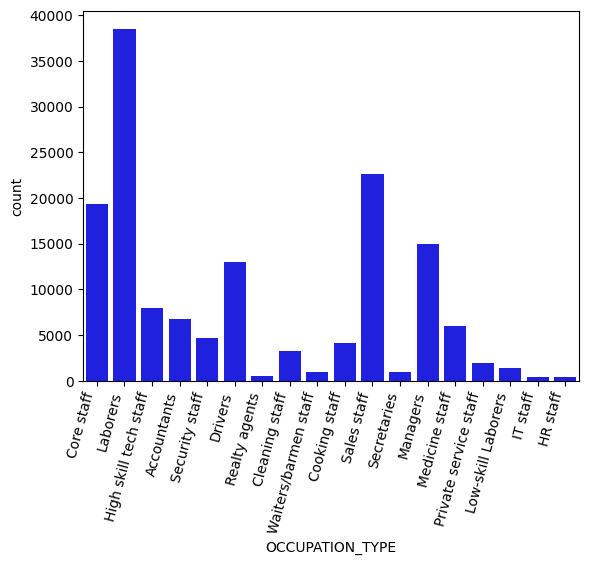

In [23]:
chart = sns.countplot(data=app_train, x="OCCUPATION_TYPE", color="blue")
chart.set_xticklabels(chart.get_xticklabels(), rotation=75, horizontalalignment='right')

### Family status of the applicants

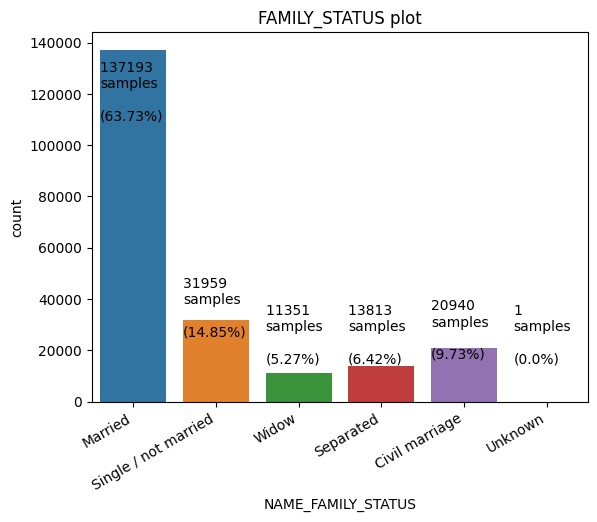

In [25]:
colu = "NAME_FAMILY_STATUS"

chart = sns.countplot(data=app_train, x=colu, orient="v")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right')
chart.set_title(f"{colu[5:]} plot")

for p in chart.patches:
    txt = str((p.get_height()*100/len(app_train)).round(2)) + '%'
    chart.text(p.get_x(),max(p.get_height()*.8, 15000) , f"{p.get_height()} \nsamples\n\n({txt})")

1.13. Plot the income type of applicants grouped by the target variable

We first display, for each posible value of NAME_INCOME_TYPE, both total occurrences, and the occurrences among the rows where TARGET==1.

In [26]:
x = app_train.groupby(["NAME_INCOME_TYPE", "TARGET"])["NAME_INCOME_TYPE"].count().to_dict()
x

{('Businessman', 0): 6,
 ('Commercial associate', 0): 46309,
 ('Commercial associate', 1): 3729,
 ('Maternity leave', 0): 1,
 ('Maternity leave', 1): 2,
 ('Pensioner', 0): 36660,
 ('Pensioner', 1): 2077,
 ('State servant', 0): 14348,
 ('State servant', 1): 879,
 ('Student', 0): 10,
 ('Unemployed', 0): 11,
 ('Unemployed', 1): 2,
 ('Working', 0): 100537,
 ('Working', 1): 10686}

In [34]:
colu = "NAME_INCOME_TYPE"

df_0 = app_train[colu].value_counts() \
                      .to_frame("total") \
                      .assign(target_1 = df_0.index \
                                             .to_series() \
                                             .apply(lambda s: len(app_train.loc[(app_train.TARGET==1) &
                                                                                (app_train.NAME_INCOME_TYPE==s)
                                                                                ]
                                                                  )
                                                    )
                              ) \
                      .assign(target_0 = df_0.iloc[:,0] - df_0.iloc[:,1])
df_0

,total,target_1,target_0
Working,111223,10686,100537
Commercial associate,50038,3729,46309
Pensioner,38737,2077,36660
State servant,15227,879,14348
Unemployed,13,2,11
Student,10,0,10
Businessman,6,0,6
Maternity leave,3,2,1


There are clearly only 4 truly relevant income types, the other have too few samples.

[Text(0, 0, 'Commercial associate'),
 Text(1, 0, 'Working'),
 Text(2, 0, 'Pensioner'),
 Text(3, 0, 'State servant')]

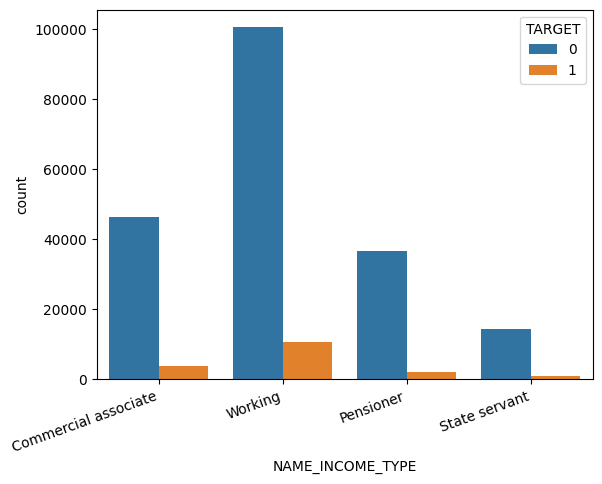

In [35]:
abundant_cats = ["Working", "Commercial associate", "Pensioner", "State servant"]
data_income = app_train.loc[app_train.NAME_INCOME_TYPE.isin(abundant_cats)]

chart = sns.countplot(data = data_income, x = "NAME_INCOME_TYPE", hue = "TARGET")
chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')
#chart.set_yscale("log")

## 2. Preprocessing

2.1. The first step will be separate our train and test datasets columns between Features and Targets.

- Assign to `X_train` those columns from `app_train` that should be used as features for training our models.
- Assign to `y_train` the single column from `app_train` that should be used as our target (i.e. what we want to predict).
- Assign to `X_test` those columns from `app_test` that should be used as features for training our models.
- Assign to `y_test` the single column from `app_test` that should be used as our target (i.e. what we want to predict).


In [14]:
aux_list = list(app_train.columns)
aux_list.remove("TARGET")

y_train = app_train.TARGET
y_test  = app_test.TARGET

X_train = app_train[aux_list].copy()
X_test  = app_test[aux_list].copy()

#df = pd.read_csv("HomeCredit_columns_description.csv")[["Row", "Description", "Special"]]

**Don't change anything in this cell, just make it run correctly**

# 2.2. Function for the data pre processing. 

 - Take `X_train`, `X_test` dataframes, process all features, and return the transformed data as numpy arrays ready to be used for training.
 - Correct outliers/anomalous values in numerical columns (hint: take a look at the DAYS_EMPLOYED column)
 - Impute values for all columns with missing data (use median as imputing value)
 - Encode categorical features:
    - If feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
 - Feature scaling

You could get different number of columns in train and test because some category could only be present in one of the dataframes, this could create more one hot encoded columns. Use `pandas.DataFrame.align()` to make train and test have the same number of columns.

Complete the function `preprocess_data(train_df: pd.DataFrame, test_df: pd.DataFrame)` following the instructions given above.

In [15]:
integer_non_cat_cols, nonbinary_cat_cols, binary_cols, mono_train_cols = [], [], [], []

for x in X_train.select_dtypes(include="int64").columns:
    if X_train[x].nunique() > 4:
        integer_non_cat_cols.append(x)
    elif 2 < X_train[x].nunique():
        nonbinary_cat_cols.append(x)
    elif 2 == X_train[x].nunique():
        binary_cols.append(x)
    else:
        mono_train_cols.append(x)
        
categoric_cols = list(app_train.select_dtypes(include="object").columns)

for x in categoric_cols + nonbinary_cat_cols:
    if X_train[x].nunique() > 2:
        nonbinary_cat_cols.append(x)
    elif X_train[x].nunique() == 2:
        binary_cols.append(x)
    else:
        mono_train_cols.append(x)

# A little bit more EDA

#### Outliers

The outliers are of course, only possible for the numerical data. But as we mentioned, some int64 columns are indeed categoric. Letś look at the ones that are not categoric:

In [16]:
print("Column".ljust(30)+"Numique", "\n","-"*50)
for x in integer_non_cat_cols:
    print(f"{x}".ljust(30), "\t",X_train[x].nunique())

Column                        Numique 
 --------------------------------------------------
Unnamed: 0                     	 215257
SK_ID_CURR                     	 215257
CNT_CHILDREN                   	 14
DAYS_BIRTH                     	 17384
DAYS_EMPLOYED                  	 11762
DAYS_ID_PUBLISH                	 6119
HOUR_APPR_PROCESS_START        	 24


"Unnamed: 0", "SK_ID_CURR" are index-type columns. Some applicants have a lot of children(CNT_CHILDREN), but it could be possible. 

HOUR_APPR_PROCESS_START could even be considered categorical.

DAYS_BIRTH, DAYS_ID_PUBLISH look fine. 

DAYS_EMPLOYED has a weird ugly value, we replace it with NaNs. Those are the only outliers we need to handle.

Text(0.5, 1.0, 'DAYS_ID_PUBLISH indicates values between 0 and 17 years.')

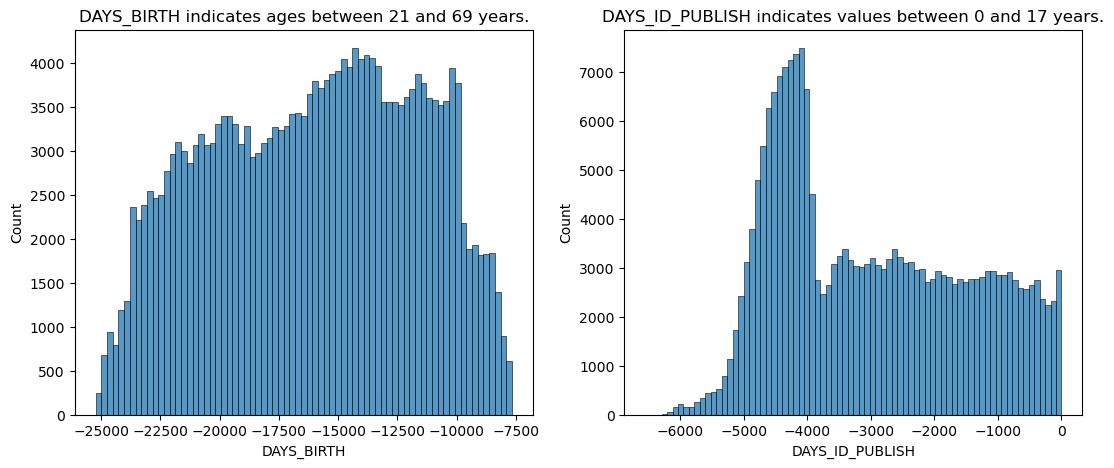

In [17]:
fig, ax = plt.subplots(1,2, figsize = (13,5))
sns.histplot(data = X_train, x = "DAYS_BIRTH", ax=ax[0])
sns.histplot(data = X_train, x = "DAYS_ID_PUBLISH", ax=ax[1])

age_max, age_min = int(-X_train.DAYS_BIRTH.min()/365), int(-X_train.DAYS_BIRTH.max()/365)
ax[0].set_title(f"DAYS_BIRTH indicates ages between {age_min} and {age_max} years.")

age_max, age_min = int(-X_train.DAYS_ID_PUBLISH.min()/365), int(-X_train.DAYS_ID_PUBLISH.max()/365)
ax[1].set_title(f"DAYS_ID_PUBLISH indicates values between {age_min} and {age_max} years.")

In the following 2 cells we can see the outlier in DAYS_EMPLOYED.

In [44]:
z = "DAYS_EMPLOYED"
print(z,
      df.loc[df.Row==z].Description.values[0],
      f"Min = {X_train[z].min()}",
      f"Max = {X_train[z].max()}",
      f"NaNs = {X_train[z].isna().sum()}"
      ,sep="\n")

DAYS_EMPLOYED
How many days before the application the person started current employment
Min = -17583
Max = 365243
NaNs = 0


In [18]:
np.sort(X_train.DAYS_EMPLOYED.unique())[-10:]

array([   -10,     -9,     -8,     -7,     -5,     -4,     -3,     -1,
            0, 365243])

In [24]:
### Complete in this cell: Data pre processing function
def preprocess_data(X_train: pd.DataFrame, X_test: pd.DataFrame):# -> Tuple[np.ndarray, np.ndarray]:
    """
    Pre processes data for modeling. Receives train and testing dataframes 
    for Home Credit Competition, and returns numpy ndarrays of cleaned up 
    dataframes with feature engineering already performed.
  
    Arguments:
      train_df: pd.DataFrame
      test_df: pd.DataFrame
      
    Returns:
      train_data: np.ndarrary
      test_data: np.ndarrary
    """
    # drop the index type columns, and FLAG_MOBIL which is constant in the train_dataset.
    cols_to_drop = ['Unnamed: 0', 'SK_ID_CURR',"FLAG_MOBIL", "FLAG_DOCUMENT_12"]
    X_train = X_train.drop(cols_to_drop, axis=1)
    X_test = X_test.drop(cols_to_drop, axis=1)

    # Distinguish relevant lists of columns
    categoric_cols = list(X_train.select_dtypes(include="object").columns)    
    for_onehot = [x for x in categoric_cols if X_train[x].nunique()>2]
    binaries_to_encode = [x for x in categoric_cols if X_train[x].nunique()<3]
    float_cols = list(X_train.select_dtypes(include="float64").columns)
    

    # Handle outliers of DAYS_EMPLOYED
    ugly_value = X_train.DAYS_EMPLOYED.max()
    impu = SimpleImputer(missing_values = ugly_value, strategy='median')
    X_train[["DAYS_EMPLOYED"]] = impu.fit_transform(X_train[["DAYS_EMPLOYED"]])
    X_test[["DAYS_EMPLOYED"]] = impu.transform(X_test[["DAYS_EMPLOYED"]])
    
    # Impute categorical columns with most frequent
    impu = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    X_train[categoric_cols] = impu.fit_transform(X_train[categoric_cols])
    X_test[categoric_cols] = impu.transform(X_test[categoric_cols])
    
    # Impute float columns with median
    impu = SimpleImputer(missing_values=np.nan, strategy='median')
    X_train[float_cols] = impu.fit_transform(X_train[float_cols])
    X_test[float_cols] = impu.transform(X_test[float_cols])
    
    # Encode categorical binaries with BinaryEncoder, while droping original columns
    # Encode other categoricals with OneHotEncoder, while droping original columns
    encoder_dict = {ce.BinaryEncoder(): binaries_to_encode,
                    ce.OneHotEncoder(): for_onehot
                   }

    for encoder_, enc_list in encoder_dict.items():
        encoder = encoder_
        transformed_data = encoder.fit_transform(X_train[enc_list])
        transformed_test_data = encoder.transform(X_test[enc_list])

        X_train = X_train.drop(enc_list, axis=1)
        X_test = X_test.drop(enc_list, axis=1)

        X_train = pd.concat([X_train, transformed_data], axis=1)
        X_test = pd.concat([X_test, transformed_test_data], axis=1)
        
    
    # We employ several scaling methods for some int64 columns
    # For float columns in particular, we use RobustScaler to handle the outliers.
    scalers_dict = { MinMaxScaler():["HOUR_APPR_PROCESS_START", "CNT_CHILDREN"], 
                     StandardScaler():["DAYS_BIRTH", "DAYS_ID_PUBLISH"], 
                     RobustScaler():["DAYS_EMPLOYED"]+float_cols 
                   }

    for scaler_0,columns_sublist in scalers_dict.items():
        scaler = scaler_0
        X_train[columns_sublist] = scaler.fit_transform(X_train[columns_sublist])
        X_test[columns_sublist] = scaler.transform(X_test[columns_sublist])
        
    train_data, test_data  = X_train.align(X_test, join="outer", axis=1)
    
    return train_data.to_numpy(), test_data.to_numpy()

 - Correct outliers/anomalous values in numerical columns (hint: take a look at the DAYS_EMPLOYED column)
 - Feature scaling
Complete the function `preprocess_data(train_df: pd.DataFrame, test_df: pd.DataFrame)` following the instructions given above.

In [25]:
train_data, test_data = preprocess_data(X_train, X_test)

/home/eduardo/miniconda3/envs/anyone_1_2/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/home/eduardo/miniconda3/envs/anyone_1_2/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/home/eduardo/miniconda3/envs/anyone_1_2/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/home/eduardo/miniconda3/envs/anyone_1_2/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [26]:
if isinstance(train_data, np.ndarray):
  print('Success: train_data type is correct!')
else:
  raise ValueError('Train dataset type is incorrect, please review your code')

Success: train_data type is correct!


## 3. Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

**Pro tip:** It is of utmost importance to make an accurate estimation of the time required to train a machine learning model. Because of this, we recommend you to use Python [time](https://docs.python.org/3/library/time.html) library or Jupyter magic function `%%time` on the cell you're training your model to get an estimate of the time it took to fit your data.

### Baseline: LogisticRegression

3.1. Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter.

Assign the trained model to `log_reg` variable.

In [27]:
### Complete in this cell: train a logistic regression, assign to `log_reg` variable
log_reg = LogisticRegression()

In [28]:
%%time
log_reg.fit(train_data, y_train)

CPU times: user 12.1 s, sys: 73.6 ms, total: 12.2 s
Wall time: 3.18 s


/home/eduardo/miniconda3/envs/anyone_1_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [29]:
if isinstance(log_reg, LogisticRegression):
  print('Success: Logistic regression model type is correct!')
else:
  raise ValueError('Logistic regression model type is incorrect, please review your code')

check_is_fitted(log_reg)

Success: Logistic regression model type is correct!


3.2. Use the trained model to predict probabilities for the test data.

**Important note:** When using the function `predict_proba()` for getting model probabilities you will get, for each sample, a tuple indicating the probability for class 0 and for class 1 respectively. For computing the AUC ROC score we only need the probability that the debt is not repaid (equivalent to class 1).

In [100]:
### Complete in this cell: predict test data
log_reg.predict_proba(test_data)

array([[0.94586256, 0.05413744],
       [0.9757044 , 0.0242956 ],
       [0.88619699, 0.11380301],
       ...,
       [0.80922116, 0.19077884],
       [0.97078289, 0.02921711],
       [0.9893244 , 0.0106756 ]])

3.3. Get AUC ROC score on test dataset. See [scikit-learn AUC ROC function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for a working implementation.

Assign the AUC ROC score to `lr_roc_auc` variable.


In [101]:
### Complete in this cell: calculate roc_auc_score.
### Assign to `lr_roc_auc` variable.
lr_roc_auc = roc_auc_score(y_test, log_reg.predict_proba(test_data)[:,1])

At this point, the model should produce a result around 0.67 

### Training a Random Forest Classifier 

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn. 

3.4. Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for n_jobs, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

Assign the trained model to `rf` variable.

In [30]:
rf = RandomForestClassifier(n_jobs=-1)

In [31]:
%%time
rf.fit(train_data, y_train)

CPU times: user 2min 26s, sys: 287 ms, total: 2min 26s
Wall time: 19.8 s


RandomForestClassifier(n_jobs=-1)

In [32]:
rf_roc_auc = roc_auc_score(y_test, rf.predict_proba(test_data)[:,1])
rf_roc_auc

0.712754987497424

# Randomized Search with Cross Validation

Hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 

3.7. Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier. The validation metric used to evaluate the models should be "roc_auc" (i.e. `scoring="roc_auc"`).

Assign the trained model to `rf_random` variable.

In [ ]:
%%time

rf_1 = RandomForestClassifier()

param_dist = {"criterion" : ["gini", "entropy"],
              "max_features" : ["sqrt", "log2"],
              "random_state" : [20, 8, 71, 86, 84, 55, 50, 4, 6, 62, 21, 32, 75, 93, 82], 
              "max_samples" : [5000, 10000, 20000, 50000]           
             }

model_grid_2 = RandomizedSearchCV(rf_1 , param_dist, n_iter=200, random_state=0, n_jobs=-1, cv=5, scoring="roc_auc")
model_grid_2.fit(train_data, y_train)

rf_random = model_grid_2.best_estimator_

## The cell took 49 minutes to run.

But I moved it up in the code and the %%time count disappeared.

## rf_random = RandomForestClassifier(criterion='entropy', max_samples=50000, random_state=82

In [34]:
rf_random = RandomForestClassifier(criterion='entropy', max_samples=50000, random_state=82)
rf_random.fit(train_data, y_train)

RandomForestClassifier(criterion='entropy', max_samples=50000, random_state=82)

3.8. Use the classifier to predict probabilities on the test set.


In [125]:
### Complete in this cell: predict test data and save csv
rf_random.predict_proba(test_data)[:,1]

array([0.15, 0.05, 0.13, ..., 0.1 , 0.  , 0.02])

In [35]:
### Complete in this cell: calculate roc_auc_score.
### Assign to `rf_tuned_roc_auc` variable.
roc_auc_score(y_test, rf_random.predict_proba(test_data)[:,1])

0.7213435038045882

In [ ]:
# create an iterator object with write permission - model.pkl
with open('model_pkl_2', 'wb') as files:
    pickle.dump(rf_random, files)